In [1]:
import pandas as pd
import requests
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns


In [380]:
# models with logprobs

gpt4_df = pd.read_parquet('data/forkevin/generated_data2/gpt4.pqt')
gpt35_df = pd.read_parquet('data/forkevin/generated_data2/gpt35.pqt')
llama_df = pd.read_parquet('data/forkevin/generated_data2/llama3.pqt')

gpt4_df['avg_prior_prob'] = gpt4_df['prior_logprobs'].apply(lambda x: np.mean([np.exp(i) for i in eval(x)]))
gpt4_df['avg_post_prob'] = gpt4_df['post_logprobs'].apply(lambda x: np.mean([np.exp(i) for i in eval(x)]))

gpt35_df['avg_prior_prob'] = gpt35_df['prior_logprobs'].apply(lambda x: np.mean([np.exp(i) for i in eval(x)]))
gpt35_df = gpt35_df[~gpt35_df['post_logprobs'].isnull()]
gpt35_df['avg_post_prob'] = gpt35_df['post_logprobs'].apply(lambda x: np.mean([np.exp(i) for i in eval(x)]))

llama_df['avg_prior_prob'] = llama_df['prior_logprobs'].apply(lambda x: np.mean([np.exp(i) for i in eval(x)]))
llama_df['avg_post_prob'] = llama_df['post_logprobs'].apply(lambda x: np.mean([np.exp(i) for i in eval(x)]))

# models without logprobs
opus_df = pd.read_parquet('data/forkevin/generated_data2/claudeopus.pqt')
sonnet_df = pd.read_parquet('data/forkevin/generated_data2/claudesonnet.pqt')
gemini_df = pd.read_parquet('data/forkevin/generated_data2/gemini15flash.pqt')

/Users/wue/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wue/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


### Figure 1: Prior Prob vs Preference Rate

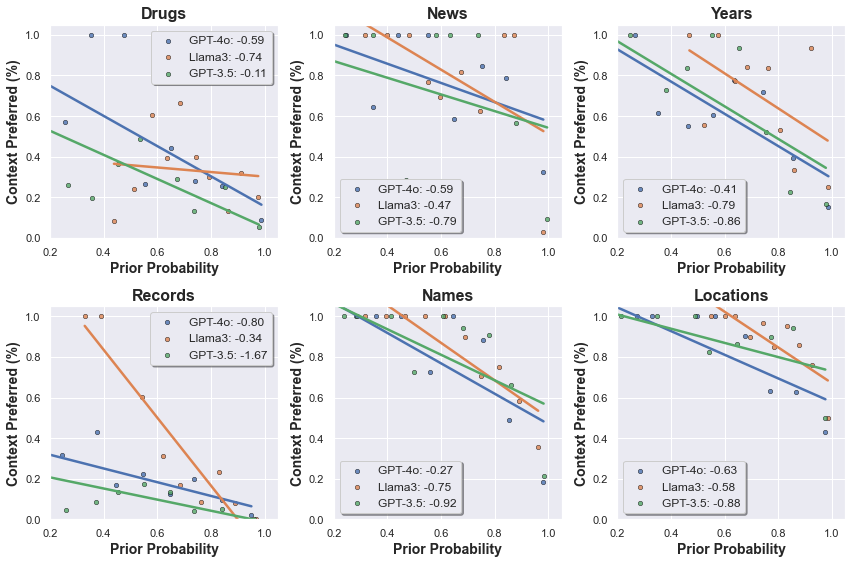

In [381]:
dataframes = [gpt4_df, llama_df, gpt35_df]
labels = ["GPT-4o", "Llama3", "GPT-3.5"]

xlabel = "Absolute Log Fold Change"

# Set the figure size and style
fig, axs = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 grid
sns.set_style("dark")
sns.set_theme(style="darkgrid")

for i, df_name in enumerate(['drugs', 'news', 'years', 'records', 'names', 'locations']):
    row, col = divmod(i, 3)
    ax = axs[row, col]
    
    for df, label in zip(dataframes, labels):
        df_filtered = df[df['dataset'] == df_name].copy()
        df_filtered = df_filtered[~(df_filtered['prior_correct'] == df_filtered['post_correct'])]
        
        df_filtered["avg_prior_prob_bins"] = pd.cut(df_filtered["avg_prior_prob"], bins=10, labels=False)
        average_win_per_prob_bin = (df_filtered.groupby("avg_prior_prob_bins")["post_correct"].mean()).reset_index()
        average_win_per_prob_bin["avg_prior_prob"] = average_win_per_prob_bin["avg_prior_prob_bins"].apply(
            lambda x: df_filtered[df_filtered["avg_prior_prob_bins"] == x]["avg_prior_prob"].mean()
        )

        # Scatter plot
        sns.scatterplot(
            data=average_win_per_prob_bin,
            x="avg_prior_prob",
            y="post_correct",
            s=20,
            edgecolor="black",
            linewidth=0.5,
            alpha=0.8,
            # color=color,
            ax=ax,
            label=f'{label}: {slope:.2f}'
        )

        # Linear regression line
        x = average_win_per_prob_bin["avg_prior_prob"]
        y = average_win_per_prob_bin["post_correct"]
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope * x + intercept, linestyle="-", linewidth=2.5)
        
    ax.set_xlabel("Prior Probability", fontsize=14, fontweight="bold")
    ax.set_ylabel("Context Preferred (%)", fontsize=14, fontweight="bold")
    ax.set_xlim([0.2, 1.05])
    ax.set_ylim([0.0, 1.05])
    ax.set_title(f"{df_name.capitalize()}", fontsize=16, fontweight="bold")
    ax.legend(frameon=True, shadow=True, fontsize=12)

plt.tight_layout()
plt.savefig("images/fig1.png", dpi=300)
plt.show()

### Figure 2: Deviation vs Preference Rate

In [341]:
def convert_time(time_str):
    parts = time_str.split(':')
    total_seconds = 0.0
    total_minutes = 0.0
    
    if len(parts) == 3:  # Format: HH:MM:SS.milliseconds
        hours = float(parts[0])
        minutes = float(parts[1])
        seconds = float(parts[2])
        total_seconds = hours * 3600 + minutes * 60 + seconds
    elif len(parts) == 2:  # Format: MM:SS.milliseconds
        minutes = float(parts[0])
        seconds = float(parts[1])
        total_seconds = minutes * 60 + seconds
    elif len(parts) == 1:  # Format: SS.milliseconds
        seconds = float(parts[0])
        total_seconds = seconds
    else:
        return 0, 1
    
    total_minutes = total_seconds / 60
    
    return total_seconds, total_minutes
    
def compare_times(time1: str, time2: str) -> bool:
    time1 = str(time1)
    time2 = str(time2)
    time1_ = ''.join([x for x in time1 if x.isdigit()]).rstrip('0')
    time2_ = ''.join([x for x in time2 if x.isdigit()]).rstrip('0')
    if time1_ in time2_ or time2_ in time1_:
        return True
    def get_combinations(time_str):
        # time_str = ''.join([x for x in time_str if x.isdigit() or x == '.']).rstrip('0').rstrip('.')
        total_seconds, total_minutes = convert_time(time_str)
        return [total_seconds, total_minutes]
    
    try:
        time1_combinations = get_combinations(time1)
        time2_combinations = get_combinations(time2)
        
        for t1 in time1_combinations:
            for t2 in time2_combinations:
                if abs(t1-t2) <= 0.1:
                    return True
    except:
        return False
    
    return False
    
def normalize_name(name: str) -> str:
    # Split the name into parts
    parts = name.split()
    # Convert to lower case
    parts = [part.lower() for part in parts]
    # Remove special characters
    parts = [re.sub(r'[^a-z]', '', part) for part in parts]
    # Join the parts back into a string
    normalized_name = " ".join(parts)
    return normalized_name

def compare_names(name1: str, name2: str) -> bool:
    normalized_name1 = normalize_name(name1)
    normalized_name2 = normalize_name(name2)

    # Split normalized names into parts
    parts1 = normalized_name1.split()
    parts2 = normalized_name2.split()

    if len(parts1) == 1:
        # Check if the single name part is in the second name
        return parts1[0] in normalized_name2
    elif len(parts2) == 1:
        # Check if the single name part is in the first name
        return parts2[0] in normalized_name1
    else:
        # Compare the full normalized names
        return int(normalized_name1 == normalized_name2)

def transform(input_string):
    # Check if the string contains any alphabetic characters
    if re.search("[a-zA-Z]", input_string):
        return None

    total_milliseconds = 0

    # Handle formats with colons (hours:minutes:seconds or minutes:seconds.milliseconds)
    if ":" in input_string:
        parts = input_string.split(":")

        if len(parts) == 3:  # Format is hours:minutes:seconds
            hours, minutes, seconds = map(int, parts)
            total_milliseconds = ((hours * 60 + minutes) * 60 + seconds) * 1000
        elif (
            len(parts) == 2
        ):  # Format is minutes:seconds or minutes:seconds.milliseconds
            minutes, seconds_ms = parts
            if "." in seconds_ms:  # minutes:seconds.milliseconds
                seconds, milliseconds = map(int, seconds_ms.split("."))
                total_milliseconds = (int(minutes) * 60 + seconds) * 1000 + milliseconds
            else:  # minutes:seconds
                seconds = int(seconds_ms)
                total_milliseconds = (int(minutes) * 60 + seconds) * 1000
    else:
        # Handle formats without colons, which might be seconds.milliseconds or minutes.seconds.milliseconds
        parts = input_string.split(".")

        if len(parts) == 3:  # Format is minutes.seconds.milliseconds
            minutes, seconds, milliseconds = map(int, parts)
            total_milliseconds = (minutes * 60 + seconds) * 1000 + milliseconds
        elif len(parts) == 2:  # Format is seconds.milliseconds
            seconds, milliseconds = map(int, parts)
            total_milliseconds = seconds * 1000 + milliseconds
        else:  # Pure seconds
            total_milliseconds = int(input_string) * 1000

    return total_milliseconds

import re

def remove_non_numeric(s):
    return re.sub(r'[^0-9]', '', s)


def get_win(row):
    if row['dataset'] == 'records':
        # print('records')
        correct = compare_times(str(row['post_response']), str(row['answer_mod']))
    elif row['dataset'] == 'names' or row['dataset'] == 'locations':
        # print('names')
        correct = compare_names(row['post_response'], row['answer_mod'])
    else:
        try:
            if type(row['post_response']) == str:
                row['post_response'] = float(remove_non_numeric(row['post_response']))
            if type(row['answer_mod']) == str:
                row['answer_mod'] = float(remove_non_numeric(row['answer_mod']))
            
            correct = int(row['answer_mod'] == row['post_response'])
        except Exception as e:
            # print(row['post_response'], '|', row['answer_mod'])
            # print(e)
            # print(row['post_response'], "|", float(row['answer_mod']))
            return 0
    return correct

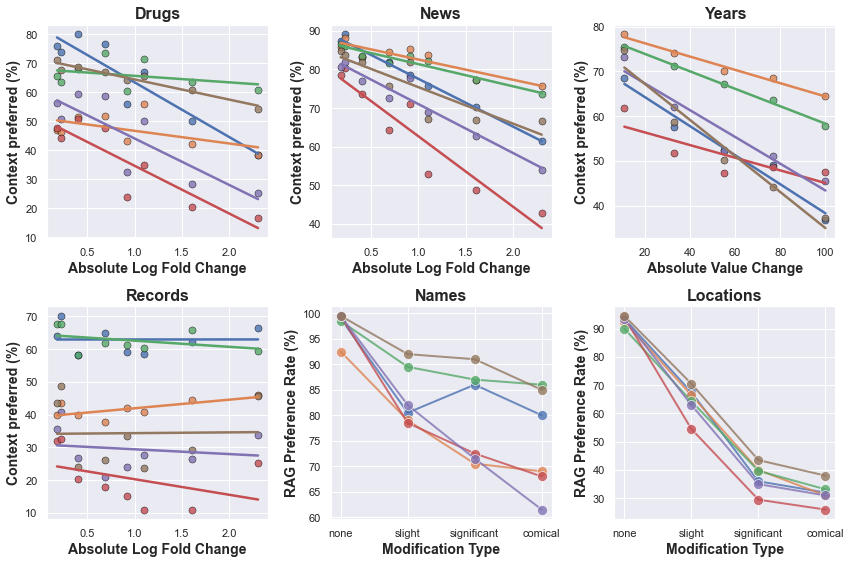

In [414]:
dataframes = [gpt4_df, llama_df, gpt35_df, opus_df, sonnet_df, gemini_df]
labels = ["GPT-4o", "Llama-3", "GPT-3.5", "Claude Opus", "Claude Sonnet", "Gemini 1.5"]

# First, the continuous deviation datasets


datasets = ['drugs', 'news', 'years', 'records']

# Set the figure size and style
fig, axs = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 grid
sns.set_style("dark")
sns.set_theme(style="darkgrid")

mods = np.abs(np.log([0.1, 0.2, 0.4, 0.8, 1.2, 1.5, 2.0, 3.0, 5.0, 10.0]))

for i, df_name in enumerate(datasets):
    row, col = divmod(i, 3)
    ax = axs[row, col]    
    for df, label in zip(dataframes, labels):
        df_filtered = df[df['dataset'] == df_name].copy()
        df_filtered["mod_type"] = df_filtered["mod_type"].astype(np.float32)
        if df_name != 'records':
            df_filtered['answer_mod'] = df_filtered['answer_mod'].apply(lambda x: float(remove_non_numeric(x)))
        df_filtered = df_filtered[(df_filtered["mod_type"].notnull()) & (df_filtered["mod_type"] != 0)]
        
        if df_name != 'years':
            xlabel = "Absolute Log Fold Change"

            for question, rows in df_filtered.groupby('question'):
                if len(rows) != 10:
                    # print("not enough")
                    continue
                if df_name == 'records':
                    rows['mod_type'] = rows['mod_type'].astype(np.float32)
                    mod_idx = rows.sort_values('mod_type', ascending=True).index
                else:
                    mod_idx = rows.sort_values('answer_mod', ascending=True).index
                df_filtered.loc[mod_idx, 'mod_abs'] = mods
        else:
            xlabel = "Absolute Value Change"
            df_filtered['mod_abs'] = np.abs(df_filtered['mod_type'].values)

        df_filtered['post_preferred'] = df_filtered.apply(get_win, axis=1)
        
        grouped_data2a = df_filtered.round(3).groupby("mod_abs")["post_preferred"].apply(lambda x: x.mean() * 100)
        x = grouped_data2a.index
        y = grouped_data2a.values
        slope, intercept = np.polyfit(x, y, 1)

        ax.plot(
            x,
            slope * x + intercept,
            # color=color,
            linestyle="-",
            linewidth=2.5,
        )

        if df_name != 'years':
            slope /= 100.

        sns.scatterplot(
            x=x,
            y=y,
            s=50,
            edgecolor="black",
            linewidth=0.5,
            alpha=0.8,
            ax=ax,
        )

    ax.set_xlabel(xlabel, fontsize=14, fontweight="bold")
    ax.set_ylabel("Context preferred (%)", fontsize=14, fontweight="bold")
    ax.set_title(f"{df_name.capitalize()}", fontsize=16, fontweight="bold")

# Then, the categorical deviation datasets

datasets = ['names', 'locations']

xlabel = "Modification Type"
order = ["none", "slight", "significant", "comical"]

sns.set_style("dark")
sns.set_theme(style="darkgrid")

for i, df_name in enumerate(datasets):
    row, col = divmod(i+4, 3)
    ax = axs[row, col]
    
    for df,  label in zip(dataframes,  labels):
        df_filtered = df[df['dataset'] == df_name].copy()
        df_filtered = df_filtered[(df_filtered["mod_type"].notnull()) & (df_filtered["mod_type"] != 0)]
        df_filtered['post_preferred'] = df_filtered.apply(get_win, axis=1)
        
        grouped_data2a = df_filtered.groupby("mod_type")["post_preferred"].apply(lambda x: x.mean() * 100)
        grouped_data2a.index = order
        x = grouped_data2a.index
        y = grouped_data2a.values

        sns.lineplot(
            x=x,
            y=y,
            # s=50,
            marker="o",
            markersize=10,
            linewidth=2,
            alpha=0.8,
            # color=color,
            # label=f"{label}",
            ax=ax,
        )

    ax.set_xlabel(xlabel, fontsize=14, fontweight="bold")
    ax.set_ylabel("RAG Preference Rate (%)", fontsize=14, fontweight="bold")
    ax.set_title(f"{df_name.capitalize()}", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig("images/fig2.png", dpi=300)
plt.show()